<a href="https://colab.research.google.com/github/bagascahyawiguna/RecommendationSystem/blob/main/RecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Film - GroupLens MovieLens 📚

Notebook ini membangun sistem rekomendasi Film menggunakan dataset [MovieLens Dataset](https://grouplens.org/datasets/movielens/latest/). Sistem rekomendasi akan dikembangkan menggunakan dua pendekatan utama:

1. **Content-Based Filtering** – Memberikan rekomendasi berdasarkan kemiripan konten Film.
2. **Collaborative Filtering** – Memberikan rekomendasi berdasarkan perilaku pengguna lain yang mirip.

Tujuan proyek ini adalah membantu pengguna menemukan Film yang relevan dengan preferensinya.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Library**

In [1]:
!pip install numpy==1.23.5
!pip install scikit-surprise
!pip install tensorflow==2.12.0

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp311-cp311-linux_x86_64.whl size=2461550 sha256=4d10c9bad7a945dcac498700bba8effb407311d9a204065fe35fb15b89ad9585
  Stored in directory: /root/.cache/pip/wheels/2a/8f/6e/7e2899163e2d85d8266daab4aa1cdabec7a6c56f83c015b5af
Successfully built scikit-surprise
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 966.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [3]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Content-based
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Collaborative Filtering
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Others
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# **Load Dataset**


In [4]:
# Load all dataset files
movies = pd.read_csv('/content/drive/MyDrive/Dataset/SistemRekomendasi/Movies/movies.csv')
ratings = pd.read_csv('/content/drive/MyDrive/Dataset/SistemRekomendasi/Movies/ratings.csv')
tags = pd.read_csv('/content/drive/MyDrive/Dataset/SistemRekomendasi/Movies/tags.csv')
links = pd.read_csv('/content/drive/MyDrive/Dataset/SistemRekomendasi/Movies/links.csv')

# Tampilkan jumlah entitas penting
print("Jumlah film unik:", movies['movieId'].nunique())
print("Jumlah pengguna unik:", ratings['userId'].nunique())
print("Jumlah total rating:", len(ratings))
print("Jumlah film yang diberi rating:", ratings['movieId'].nunique())
print("Jumlah film yang diberi tag:", tags['movieId'].nunique())
print("Jumlah tag unik:", tags['tag'].nunique())
print("Jumlah total entri tag:", len(tags))
print("Jumlah film yang memiliki link ke IMDb/TMDb:", links['movieId'].nunique())

Jumlah film unik: 9742
Jumlah pengguna unik: 610
Jumlah total rating: 100836
Jumlah film yang diberi rating: 9724
Jumlah film yang diberi tag: 1572
Jumlah tag unik: 1589
Jumlah total entri tag: 3683
Jumlah film yang memiliki link ke IMDb/TMDb: 9742


# **Univariate Exploratory Data Analysis**
Variabel-variabel pada MovieLens dataset adalah sebagai berikut:

**movies**: Berisi daftar film beserta genre-nya.

**ratings**: Berisi informasi penilaian atau rating yang diberikan oleh pengguna terhadap film.

**tags**: Berisi tag atau label yang ditambahkan oleh pengguna ke film tertentu.

**links**: Berisi tautan ke situs referensi film seperti IMDb dan TMDb (The Movie Database).

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [8]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


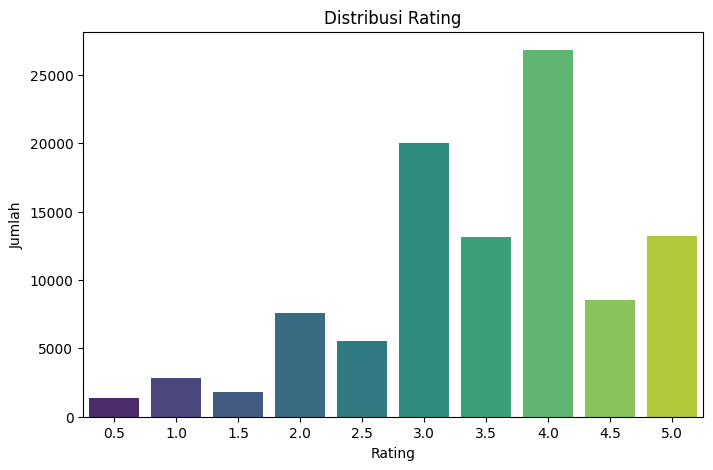

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

**Interpretasi**:
* Rating paling umum adalah 4.0, disusul oleh 3.0 dan 5.0.
* Artinya, pengguna cenderung memberikan rating positif terhadap film.
* Distribusi ini tidak simetris—cenderung ke arah rating tinggi, menunjukkan bias positif pengguna.

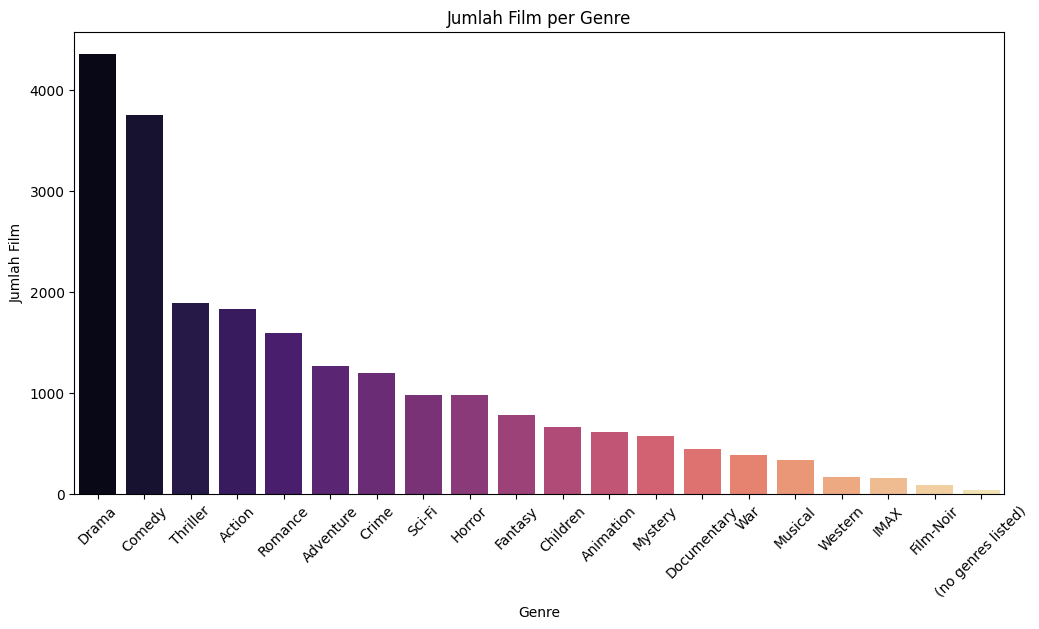

In [10]:
# Explode genre
movies_exploded = movies.copy()
movies_exploded['genres'] = movies_exploded['genres'].str.split('|')
movies_exploded = movies_exploded.explode('genres')

# Hitung jumlah film per genre
genre_counts = movies_exploded['genres'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='magma')
plt.xticks(rotation=45)
plt.title('Jumlah Film per Genre')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.show()

**Interpretasi**:
* Genre Drama dan Comedy mendominasi, masing-masing lebih dari 3500 dan 3000 film.
* Genre dengan jumlah film paling sedikit: Film-Noir, Western, dan (no genres listed).

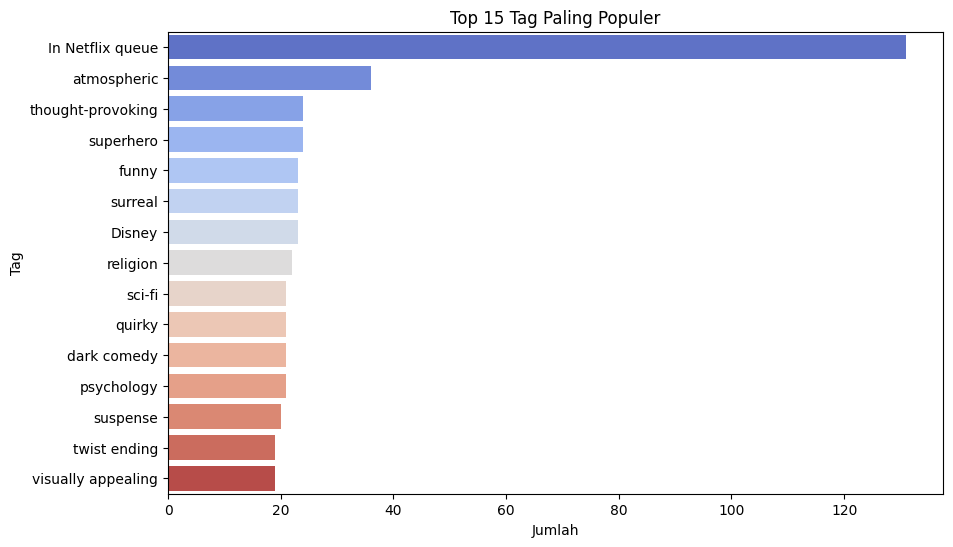

In [11]:
top_tags = tags['tag'].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_tags.index, x=top_tags.values, palette='coolwarm')
plt.title('Top 15 Tag Paling Populer')
plt.xlabel('Jumlah')
plt.ylabel('Tag')
plt.show()

**Interpretasi**:
* Tag paling umum: "In Netflix queue", jauh lebih tinggi dari tag lain.
* Banyak tag menggambarkan suasana atau gaya film, seperti: "atmospheric", "thought-provoking", "dark comedy", "surreal"

# **Data Preprocessing & Data Preparation**

## **Cek Missing Values pada setiap data**

In [12]:
print("Missing values pada movies:")
print(movies.isnull().sum())

print("\nMissing values pada ratings:")
print(ratings.isnull().sum())

print("\nMissing values pada tags:")
print(tags.isnull().sum())

print("\nMissing values pada links:")
print(links.isnull().sum())

Missing values pada movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values pada ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values pada tags:
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Missing values pada links:
movieId    0
imdbId     0
tmdbId     8
dtype: int64


* Kolom **tmdbId** pada dataset links memiliki 8 nilai kosong. Namun karena **tmdbId** tidak digunakan langsung dalam proses rekomendasi (baik content-based maupun collaborative filtering), nilai kosong ini **tidak berdampak signifikan** dan **tidak perlu dihapus** saat ini.

* **Tidak ditemukan missing values** pada dataset utama lainnya seperti **ratings**, **movies**, dan **tags**. Maka tidak perlu dilakukan imputasi atau pembersihan data tambahan pada tahap awal.

## **Cek duplikasi pada setiap data**

In [13]:
print("Duplikat di ratings:", ratings.duplicated().sum())
print("Duplikat di movies:", movies.duplicated().sum())
print("Duplikat di tags:", tags.duplicated().sum())

Duplikat di ratings: 0
Duplikat di movies: 0
Duplikat di tags: 0


Tidak ada duplikasi data

## **Cek Konsistensi ID**

In [14]:
missing_movieIds_in_ratings = ~ratings['movieId'].isin(movies['movieId'])
missing_movieIds_in_tags = ~tags['movieId'].isin(movies['movieId'])

print("movieId di ratings tapi tidak ada di movies:", ratings[missing_movieIds_in_ratings].shape[0])
print("movieId di tags tapi tidak ada di movies:", tags[missing_movieIds_in_tags].shape[0])

movieId di ratings tapi tidak ada di movies: 0
movieId di tags tapi tidak ada di movies: 0


## **Menyiapkan Data Content-Based Filtering**

* Menggabungkan tag dari tabel tags berdasarkan movieId menggunakan groupby dan join.
* Merge data hasil gabungan movie_tags ke movies berdasarkan movieId.
* Mengisi nilai kosong (NaN) pada kolom genres dan tag dengan string kosong ('').
* Menggabungkan genres dan tag menjadi satu kolom content, di mana pemisah | dihapus dan diganti dengan spasi.

In [15]:
# Menggabungkan tags dengan movies berdasarkan movieId
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()
movies_content = movies.merge(movie_tags, on='movieId', how='left')

# Mengisi nilai NaN pada kolom 'tag' dan 'genres'
movies_content['tag'] = movies_content['tag'].fillna('')
movies_content['genres'] = movies_content['genres'].fillna('')

# Membuat kolom 'content' yang merupakan gabungan dari genres dan tag
movies_content['content'] = movies_content['genres'].str.replace('|', ' ') + ' ' + movies_content['tag']

In [16]:
# Menampilkan 5 baris pertama untuk memastikan penggabungan berhasil
print("Data movies_content setelah preprocessing:")
print(movies_content.head())

Data movies_content setelah preprocessing:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  \
0  Adventure|Animation|Children|Comedy|Fantasy   
1                   Adventure|Children|Fantasy   
2                               Comedy|Romance   
3                         Comedy|Drama|Romance   
4                                       Comedy   

                                            tag  \
0                               pixar pixar fun   
1  fantasy magic board game Robin Williams game   
2                                     moldy old   
3                                                 
4                              pregnancy remake   

                                             con

Output menunjukkan 5 baris pertama dari movies_content:

Setiap film kini memiliki kolom content berupa gabungan genres dan tag.

Misalnya:

"Toy Story (1995)" → Adventure Animation Children Comedy Fantasy pixar pixar fun

Ini menyiapkan data untuk representasi teks yang akan digunakan di TF-IDF.

## **Transformasi Konten dengan TF-IDF**

* Inisialisasi TfidfVectorizer dari scikit-learn, dengan stop_words='english'.
* Melakukan fit_transform() pada kolom content dari movies_content.
* Menampilkan dimensi hasil transformasi (shape) dan beberapa baris pertama dalam bentuk dense.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_content['content'])

In [18]:
# Melihat ukuran dari matriks TF-IDF
print("\nUkuran matriks TF-IDF:")
print(tfidf_matrix.shape)


Ukuran matriks TF-IDF:
(9742, 1677)


Matriks TF-IDF berukuran (9742, 1677), artinya 9742 film direpresentasikan sebagai vektor berdimensi 1677 fitur (kata unik setelah preprocessing).

In [19]:
# Melihat beberapa baris pertama dari matriks TF-IDF dalam bentuk dens
print("\nBeberapa baris pertama matriks TF-IDF (dense):")
print(tfidf_matrix[:10].todense())


Beberapa baris pertama matriks TF-IDF (dense):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Matriks dense berisi banyak nilai nol karena representasi TF-IDF sangat sparse (jarang ada kemunculan kata yang sama di banyak film).

## **Menyiapkan Data Collaborative Filtering**

* Memfilter pengguna (userId) yang memberi minimal 10 rating.
* Memfilter film (movieId) yang mendapatkan minimal 10 rating.
* Ini bertujuan untuk mengurangi sparsity data dan meningkatkan kualitas pelatihan model.

In [20]:
# Filter user dengan minimal 10 rating
user_counts = ratings['userId'].value_counts()
active_users = user_counts[user_counts >= 10].index
ratings = ratings[ratings['userId'].isin(active_users)]

# Filter film dengan minimal 10 rating
movie_counts = ratings['movieId'].value_counts()
popular_movies = movie_counts[movie_counts >= 10].index
ratings = ratings[ratings['movieId'].isin(popular_movies)]

In [21]:
# Menampilkan beberapa baris pertama dari ratings_filtered untuk melihat perubahan
print("\nData ratings_filtered setelah filter user dan movie:")
print(ratings.head())


Data ratings_filtered setelah filter user dan movie:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


## **Pemetaan MovieId ke Judul**

* Membuat dictionary dari movieId ke title.
* Menampilkan 10 entri pertama.

In [22]:
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))

In [23]:
# Menampilkan sebagian data pemetaan movieId ke judul
print("\nPemetaan MovieId ke Judul:")
print(list(movie_id_to_title.items())[:10])  # Menampilkan 10 pasangan pertama


Pemetaan MovieId ke Judul:
[(1, 'Toy Story (1995)'), (2, 'Jumanji (1995)'), (3, 'Grumpier Old Men (1995)'), (4, 'Waiting to Exhale (1995)'), (5, 'Father of the Bride Part II (1995)'), (6, 'Heat (1995)'), (7, 'Sabrina (1995)'), (8, 'Tom and Huck (1995)'), (9, 'Sudden Death (1995)'), (10, 'GoldenEye (1995)')]


Mapping seperti (1, 'Toy Story (1995)') akan digunakan untuk menampilkan hasil rekomendasi berdasarkan judul, bukan ID numerik.

# **Model Development**

## **Content-Based Filtering**

Pada pendekatan ini, kita akan menggunakan TF-IDF Vectorization untuk mengubah kolom content (gabungan genre dan tag) menjadi vektor. Kemudian, kita akan menghitung Cosine Similarity untuk mencari film yang paling mirip dengan film yang telah diberikan rating oleh pengguna.

Langkah-langkah Content-Based Filtering:
* TF-IDF Vectorization: Ubah kolom content menjadi vektor numerik menggunakan TF-IDF Vectorizer.
* Cosine Similarity: Hitung kemiripan antara film-film berdasarkan vektor yang dihasilkan menggunakan Cosine Similarity.
* Rekomendasi Film: Berdasarkan Cosine Similarity, kita dapat menghasilkan rekomendasi film untuk setiap film.

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_content['content'])

# Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Dataframe similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_content['title'], columns=movies_content['title'])
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

title,Swiss Family Robinson (1960),Fifty Shades of Grey (2015),Dennis the Menace (1993),Shiri (Swiri) (1999),Inescapable (2012)
title,,,,,
Stir of Echoes (1999),0.000000,0.000000,0.000000,0.242932,0.000000
"Quiet Earth, The (1985)",0.000000,0.154833,0.000000,0.102860,0.097338
Sky High (2003),0.000000,0.000000,0.000000,0.561650,0.269189
Tom and Huck (1995),1.000000,0.000000,0.000000,0.000000,0.000000
Destry Rides Again (1939),0.000000,0.000000,0.359790,0.000000,0.000000
Blue Thunder (1983),0.000000,0.218370,0.000000,0.463335,0.438464
North Pole: Open For Christmas (2015),0.556102,0.000000,0.000000,0.000000,0.000000
"Follow Me, Boys! (1966)",0.000000,0.366904,0.734398,0.243745,0.230661
Barely Lethal (2015),0.431370,0.000000,0.434290,0.316227,0.299252


**Contoh kemiripan**:
* Japanese Story (2003) vs Anna and the King (1999): 0.540584
* Japanese Story (2003) vs The Squeeze (2015): 0.678719

*Semakin tinggi nilai, semakin mirip dua film tersebut berdasarkan konten teksnya.*

In [25]:
#Fungsi Rekomendasi Film Berdasarkan Judul
def movie_recommendations(movie_title, similarity_data=cosine_sim_df, items=movies_content[['title', 'genres']], k=10):
    index = similarity_data.loc[:, movie_title].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(movie_title, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

def precision_at_k_by_genre(query_title, k=10):
    query_genre = movies_content[movies_content['title'] == query_title]['genres'].values[0]
    query_genres_set = set(query_genre.split('|'))

    recommended_df = movie_recommendations(query_title, k=k)
    recommended_df['genre_match'] = recommended_df['genres'].apply(
        lambda g: len(set(g.split('|')) & query_genres_set) > 0
    )

    precision = recommended_df['genre_match'].sum() / k
    return precision

# Contoh penggunaan evaluasi
precision = precision_at_k_by_genre("Toy Story (1995)", k=10)
print(f"Precision@10 (berdasarkan genre mirip): {precision:.2f}")

Precision@10 (berdasarkan genre mirip): 1.00


In [26]:
# Uji Coba Mendapatkan rekomendasi film untuk "Toy Story (1995)"
movies_content[movies_content.title.eq("Toy Story (1995)")]
movie_recommendations("Toy Story (1995)")

,title,genres
0,"Bug's Life, A (1998)",Adventure|Animation|Children|Comedy
1,Toy Story 2 (1999),Adventure|Animation|Children|Comedy|Fantasy
2,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi
3,Asterix and the Vikings (Astérix et les Viking...,Adventure|Animation|Children|Comedy|Fantasy
4,Shrek the Third (2007),Adventure|Animation|Children|Comedy|Fantasy
5,"Monsters, Inc. (2001)",Adventure|Animation|Children|Comedy|Fantasy
6,Turbo (2013),Adventure|Animation|Children|Comedy|Fantasy
7,The Good Dinosaur (2015),Adventure|Animation|Children|Comedy|Fantasy
8,"Wild, The (2006)",Adventure|Animation|Children|Comedy|Fantasy
9,"Emperor's New Groove, The (2000)",Adventure|Animation|Children|Comedy|Fantasy


## **Collaborative Filtering**

**Tujuan**:
Memberi rekomendasi berdasarkan pola preferensi pengguna terhadap film.

**Langkah-langkah**:
* Encode userId dan movieId menjadi integer.
* Normalisasi rating ke skala 0–1.
* Split data menjadi train dan validation.
* Buat model RecommenderNet:
* Menggunakan embedding untuk user dan movie.
* Menggunakan dot product + bias → sigmoid.
* Training model selama 20 epoch.
* Visualisasi RMSE.

In [28]:
# Encode userId dan movieId
user_ids = ratings['userId'].unique().tolist()
user_to_encoded = {x: i for i, x in enumerate(user_ids)}
encoded_to_user = {i: x for i, x in enumerate(user_ids)}

movie_ids = ratings['movieId'].unique().tolist()
movie_to_encoded = {x: i for i, x in enumerate(movie_ids)}
encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

ratings['user'] = ratings['userId'].map(user_to_encoded)
ratings['movie'] = ratings['movieId'].map(movie_to_encoded)

num_users = len(user_to_encoded)
num_movies = len(movie_to_encoded)
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()

In [29]:
# Shuffle dan split data
ratings = ratings.sample(frac=1, random_state=42)
x = ratings[['user', 'movie']].values
y = ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_size = int(0.8 * len(x))
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [30]:
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size=50, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            num_users, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies, embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        return tf.nn.sigmoid(dot_user_movie + user_bias + movie_bias)

Epoch 1/20
1014/1014 [==============================] - 5s 4ms/step - loss: 0.6367 - root_mean_squared_error: 0.2391 - val_loss: 0.6114 - val_root_mean_squared_error: 0.2139
Epoch 2/20
1014/1014 [==============================] - 5s 5ms/step - loss: 0.6069 - root_mean_squared_error: 0.2083 - val_loss: 0.6150 - val_root_mean_squared_error: 0.2172
Epoch 3/20
1014/1014 [==============================] - 3s 3ms/step - loss: 0.5999 - root_mean_squared_error: 0.2009 - val_loss: 0.6064 - val_root_mean_squared_error: 0.2085
Epoch 4/20
1014/1014 [==============================] - 3s 3ms/step - loss: 0.5972 - root_mean_squared_error: 0.1980 - val_loss: 0.6022 - val_root_mean_squared_error: 0.2043
Epoch 5/20
1014/1014 [==============================] - 5s 5ms/step - loss: 0.5962 - root_mean_squared_error: 0.1969 - val_loss: 0.6030 - val_root_mean_squared_error: 0.2055
Epoch 6/20
1014/1014 [==============================] - 3s 3ms/step - loss: 0.5970 - root_mean_squared_error: 0.1978 - val_loss: 0

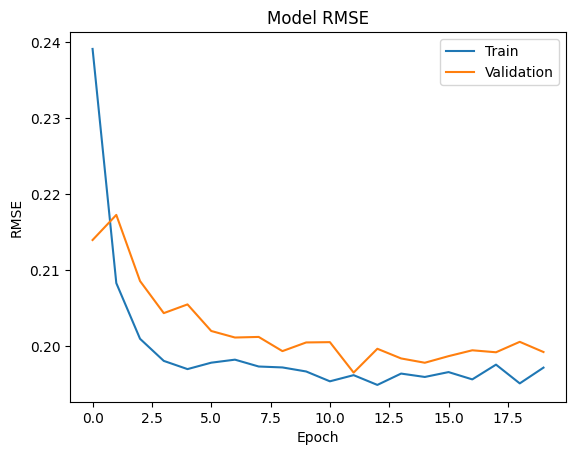

In [31]:
model = RecommenderNet(num_users, num_movies)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val)
)

# Plot hasil training
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend(['Train', 'Validation'])
plt.title('Model RMSE')
plt.show()

* RMSE training menurun drastis, validasi juga stabil.
* Overfitting tidak terjadi secara signifikan karena gap-nya kecil.
* RMSE ~0.20 pada validation berarti prediksi rating cukup mendekati rating asli (skala 0–1).

In [32]:
# Ambil sample user
user_id = ratings['userId'].sample(1).iloc[0]
user_encoded = user_to_encoded[user_id]

# Film yang sudah ditonton user
watched_movie_ids = ratings[ratings['userId'] == user_id]['movieId'].tolist()

# Film yang belum ditonton
unwatched_movies = [movie for movie in movie_ids if movie not in watched_movie_ids]
unwatched_encoded = [movie_to_encoded[movie] for movie in unwatched_movies]

# Siapkan input untuk prediksi
user_input = np.array([[user_encoded]] * len(unwatched_encoded))
movie_input = np.array(unwatched_encoded).reshape(-1, 1)
input_array = np.hstack([user_input, movie_input])

# Prediksi rating
predicted_ratings = model.predict(input_array).flatten()
top_indices = predicted_ratings.argsort()[-10:][::-1]
top_movie_ids = [encoded_to_movie[unwatched_encoded[i]] for i in top_indices]

# Tampilkan hasil rekomendasi
print(f"Menampilkan rekomendasi untuk User ID: {user_id}")
print("=" * 30)

# Film dengan rating tertinggi dari user
print("Film dengan rating tertinggi dari user:")
print("-" * 30)
top_movies_user = (
    ratings[ratings['userId'] == user_id]
    .sort_values(by='rating', ascending=False)
    .head(5)
    .movieId.values
)

for movie_id in top_movies_user:
    title = movie_id_to_title.get(movie_id, "Unknown Title")
    print(f"- {title}")

print("-" * 30)
print("Top 10 Rekomendasi Film:")
print("-" * 30)

# Tampilkan film rekomendasi
recommended_movies = movies[movies['movieId'].isin(top_movie_ids)]
for row in recommended_movies.itertuples():
    print(f"- {row.title}")


70/70 [==============================] - 0s 1ms/step
Menampilkan rekomendasi untuk User ID: 237
Film dengan rating tertinggi dari user:
------------------------------
- Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
- Shawshank Redemption, The (1994)
- Game, The (1997)
- Men in Black (a.k.a. MIB) (1997)
- One Flew Over the Cuckoo's Nest (1975)
------------------------------
Top 10 Rekomendasi Film:
------------------------------
- City of Lost Children, The (Cité des enfants perdus, La) (1995)
- Once Upon a Time in the West (C'era una volta il West) (1968)
- Godfather: Part II, The (1974)
- Raging Bull (1980)
- Rosemary's Baby (1968)
- Double Indemnity (1944)
- Guess Who's Coming to Dinner (1967)
- Lost in Translation (2003)
- There Will Be Blood (2007)
- Toy Story 3 (2010)
